In [1]:
# Setup notebook enivironment

%matplotlib widget
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage import io, measure, segmentation
from pathlib import Path
# from scipy import ndimage
from scipy.io import loadmat

# Goal

The goal of the analysis is to identify which labelled nuclei are also IF positive.
- Determine the normalised staining of the (nuclei+/IF+ cells)/area
- Determine the normalised staining of the non nuclear region in (nuclei+/IF+ cells)
- Determine the normalised staining of the nuclear region in (nuclei+/IF+ cells)


# Strategy

The DAPI signal that define the nuclei has been collected in Cyc01R and Cyc11R_IF but segmented only on Cyc01R.   
The IF signal has been collected and segmented in Cyc11R_IF therefore it needs to be registered to Cyc01R.

__STEP1__: register the IF label image Cyc11R_IF to Cyc01R   
__STEP2__: Identify the nuclei+/IF+ cells using the following criteria: _a cell is considered nuclei+/IF+ if the area of the overlapping region is >= the area of the nuclei_



## Questions

# Define working directories

In [3]:
# Define the working directories
# data_path = Path('/data/opticalbiosystems.com/Marcos Otero - 2021-06-21_Stf1-Subset_Simone')
# data_path = Path(r'C:\Users\Syousefi\Downloads\2021-06-21_Stf1-Subset_Simone')
data_path = Path(r'C:\Users\Syousefi\Downloads\2021-06-12_Stf1_Tau-dataset')
nuclei_data_path = data_path / 'Cyc01R'
# IF_data_path = data_path / 'Cyc11R_IF'
IF_data_path = data_path / 'Cyc11R_IF_segm'

segmentation_nuclei_path = nuclei_data_path / 'StarDistSegResults_v8.1'
# segmentation_IF_path = IF_data_path / 'Segmentation_IF_watershed'
segmentation_IF_path = IF_data_path / 'Segmentation_AT8'


In [4]:
new_col_name = "Tau"
global_cell_number = 'Cell No in Montage'
global_cell_number_gene_table = 'Cell No.'
cell_by_gene_path = str(data_path) + 'PCA_07072021_r1'
cell_by_gene_ = os.path.join(cell_by_gene_path, "FinalReport_PerCellAnalysis.csv")
# cell_by_gene_ = r"C:\Users\Syousefi\Downloads\2021-06-12_Stf1_Tau-dataset\PCA_07072021_r1\FinalReport_PerCellAnalysis.csv"
temp_dir = r"C:\Users\Syousefi\Downloads\2021-06-12_Stf1_Tau-dataset\temp"

cell_by_gene_table = pd.read_csv(cell_by_gene_, header=0)
cell_by_gene_table[new_col_name] = 0 

# Data exploration

In order to better understand the data I will look into the data provided by Marcos

## Load the segmented map of the nuclei

.mdat in StarDist output folder of cycle 1 in Marcos' data  
- This is the Segmentation label map in which the segmented objects are labeled with the local object ID.  Non-object (background) is labeled as "0".  
- Just raw data format: there is no header, no other information than pixel data 
- 4-byte unsigned integer per pixel
- 5464x5464 pixels in Marcos' data.  So, 5464x5464x4 = 119,421,184 bytes in file size
- Please load this data using binary file read function like fread() in C language.

## Load nuclei data

## Load the segmented map of the IF

.dat in Segmentation_IF_watershed folder cycle 11 in Marcos' data
- This is the Segmentation label map in which the segmented objects are labeled with the local object ID.  Non-object (background) is labeled as "0".
- MATLAB's MAT (.mat) file format
- double precision floating point per pixel 5464x5464 pixels in Marcos' data.  File size is not fixed due to MAT file's data compression.
- Please load this data using MAT file loader function.  I believe there is Python function to load this format data.

# Analysis

In [5]:
import os 
from os import listdir
from os.path import isfile, join
import glob 

nuclei_segmentation_method = "StarDistSegResults_v8.1"
stain_segmentation_method = "Segmentation_IF_watershed"

sao_nuclei_directory = join(nuclei_data_path, "SaoRecon")
sao_segmentation_IF_path = join(IF_data_path, 'SaoRecon_IF_watershed')

IF_files = [f for f in listdir(segmentation_IF_path) if isfile(join(segmentation_IF_path, f))]
# print(segmentation_IF_files)

# Get the DAPI segmentation images from the watershed segmentation 
stain_IF_images = [f for f in IF_files if "_dapi.png" in f.lower()]
print(" Stain images are: ", stain_IF_images)

# Get the corresponding nuclei segmented image paths 
nuclei_label_imgs = []
nuclei_label_imgs_not_found = []
nuclei_label_paths = []
stain_imgs_match = []
stain_imgs_path = []
stain_sao_path = []
nuclei_sao_path = []
for f in stain_IF_images:
    found_math = False 
    f_lower = f.lower()
    label_img = f_lower.replace("_dapi", "_labels")
    
    for root, dirnames, filenames in os.walk(segmentation_nuclei_path):
        for _i, filename in enumerate(filenames):
            if label_img in filename.lower():
                # print("corresponding path to ... ", f, "... is ... ", join(root,filename))
                nuclei_label_paths.append(join(root,filename))
                nuclei_label_imgs.append(label_img)
                stain_imgs_match.append(f)
                stain_imgs_path.append(join(segmentation_IF_path,f))
                stain_sao_path.append(join(sao_segmentation_IF_path,f.replace("dapi","Dapi")))
                nuclei_sao_path.append(join(sao_nuclei_directory,f.replace("dapi","Dapi")))
                # print(os.path.abspath(f))
                found_math = True 

    if not found_math:
        nuclei_label_imgs_not_found.append(f)

print(len(stain_imgs_match), len(nuclei_label_imgs), len(nuclei_label_paths), len(nuclei_label_imgs_not_found))
if len(nuclei_label_imgs_not_found)>0:
    print("Could not find the correspnding images for ", f)
else:
    print("All corresponding segmentations were found")

# print(nuclei_label_paths)
# print(stain_imgs_path)

 Stain images are:  ['BP25_Dapi.png', 'BQ25_Dapi.png', 'BQ26_Dapi.png', 'BQ27_Dapi.png', 'BR21_Dapi.png', 'BR22_Dapi.png', 'BR23_Dapi.png', 'BR24_Dapi.png', 'BR25_Dapi.png', 'BR26_Dapi.png', 'BR27_Dapi.png', 'BR28_Dapi.png', 'BS19_Dapi.png', 'BS20_Dapi.png', 'BS21_Dapi.png', 'BS22_Dapi.png', 'BS23_Dapi.png', 'BS24_Dapi.png', 'BS25_Dapi.png', 'BS26_Dapi.png', 'BS27_Dapi.png', 'BS28_Dapi.png', 'BT19_Dapi.png', 'BT20_Dapi.png', 'BT21_Dapi.png', 'BT22_Dapi.png', 'BT23_Dapi.png', 'BT24_Dapi.png', 'BT25_Dapi.png', 'BT26_Dapi.png', 'BT27_Dapi.png', 'BT28_Dapi.png', 'BT29_Dapi.png', 'BU19_Dapi.png', 'BU20_Dapi.png', 'BU21_Dapi.png', 'BU22_Dapi.png', 'BU23_Dapi.png', 'BU24_Dapi.png', 'BU25_Dapi.png', 'BU26_Dapi.png', 'BU27_Dapi.png', 'BU28_Dapi.png', 'BU29_Dapi.png', 'BU30_Dapi.png', 'BV19_Dapi.png', 'BV20_Dapi.png', 'BV21_Dapi.png', 'BV22_Dapi.png', 'BV23_Dapi.png', 'BV24_Dapi.png', 'BV25_Dapi.png', 'BV26_Dapi.png', 'BV27_Dapi.png', 'BV28_Dapi.png', 'BV29_Dapi.png', 'BV30_Dapi.png', 'BW20_Dapi

## Registration

In [6]:
from skimage import exposure, transform
from skimage.util import img_as_float, img_as_ubyte
from skimage.transform import rescale, resize

show_fig = False 

def rescale_and_rexpose(img, v_min, v_max, min_intensity=0, max_intensity=255):
    img_norm = max_intensity*(img-v_min)/(v_max-v_min + 0.001)
    img_ex = exposure.rescale_intensity(img_norm, in_range=(min_intensity, max_intensity))
    output_img = img_ex
    return output_img

def inv_and_saturate(img, _resize, min_intensity=0, max_intensity=255):
    img_inv = img.max() - img
    v_min, v_max = np.percentile(img_inv, (80, 95))
    # img_inv[img_inv>=v_max] = v_max
    img_inv[img_inv<=v_min] = 0
    print(v_min, v_max, img_inv.min(), img_inv.max() )
    
    if _resize>1:        
        print("Resizing")
        img_inv = resize(img_inv, (img_inv.shape[0] // 4, img_inv.shape[1] // 4), anti_aliasing=True)
    
    # img_inv = img_as_ubyte(img_inv)                   
    
    return img_inv

N_bits = 8
min_intensity, max_intensity = 0, 2**N_bits - 1
shift_translation = [82, 164]
tform = transform.SimilarityTransform(scale=1, rotation=0,
                                      translation=(shift_translation[0], shift_translation[1]))
tform_inv = transform.SimilarityTransform(scale=1, rotation=0,
                                      translation=(-1*shift_translation[0], -1*shift_translation[1]))

for _i, _f in enumerate(nuclei_sao_path):

    _f_corrected_nuc = _f.replace(".png", ".tif")
    _f_corrected_stain = stain_sao_path[_i].replace(".png", ".tif")
    if os.path.isfile(_f_corrected_nuc) and os.path.isfile(_f_corrected_stain) and _i==3:
        print(_i, _f_corrected_nuc, _f_corrected_stain)
        
        print("Loading " , _f_corrected_nuc)
        nuclei_img = img_as_float(io.imread(_f_corrected_nuc))
        nuclei_img = transform.warp(nuclei_img, tform, preserve_range=True)
        v_min, v_max = np.percentile(nuclei_img, (25, 95))
        nuclei_img_ex = rescale_and_rexpose(nuclei_img, v_min, v_max)
        nuclei_img_inv = inv_and_saturate(nuclei_img, _resize=4)

        print("Loading " , _f_corrected_stain)
        stain_img = img_as_float(io.imread(_f_corrected_stain))
        v_min, v_max = np.percentile(stain_img, (25, 99))
        stain_img_ex = rescale_and_rexpose(stain_img, v_min, v_max)
        stain_img_inv = inv_and_saturate(stain_img, _resize=4)

        img_RGB = np.zeros([stain_img_ex.shape[0],stain_img_ex.shape[1],3])
        img_RGB[:,:,0] = nuclei_img_ex
        img_RGB[:,:,1] = stain_img_ex

        img_RGB_check = np.zeros([nuclei_img_inv.shape[0],nuclei_img_inv.shape[1],3])
        img_RGB_check[:,:,0] = nuclei_img_inv
        img_RGB_check[:,:,1] = stain_img_inv
        # _ = ax.imshow(img_RGB)

        if show_fig:
            fig = plt.figure(figsize=(12,12))
            ax1 = fig.add_subplot(121)
            # ax.axis('off')
            ax1.set_title(os.path.basename(_f))
            _ = ax1.imshow(img_as_ubyte(img_RGB))

            ax2 = fig.add_subplot(122)
            # ax.axis('off')
            ax2.set_title("Overlap of the Inverse")
            _ = ax2.imshow(img_as_ubyte(img_RGB_check))


In [7]:
from skimage.measure import label, regionprops, regionprops_table
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial import distance

show_fig = False          
process_overlap = True 

def get_corresponding_nuclei_list(filepath, segmentation_path):

    filename = os.path.basename(filepath)
    _, file_extension = os.path.splitext(filepath)
    filename = filename.replace("_Dapi","_NucleiList")
    csv_name = filename.replace(file_extension, ".csv")
    csv_path = os.path.join(segmentation_path, csv_name)
    if not os.path.isfile(csv_path):
        print(f"file {csv_path} does not exitst")
    return csv_path, csv_name

def _get_centroid_label(nuclei_masks_img, _l):

                mask_img_bin = (nuclei_masks_img == _l)
                label_img = label(mask_img_bin)
                regions = regionprops(label_img)
                for _i, props in enumerate(regions):
                    if _i==0:
                        y0, x0 = props.centroid
                        centoid_xy = (x0,y0)
                return centoid_xy

print(f"Processing {len(stain_imgs_path)} files")
print(stain_imgs_path[0])
print(segmentation_nuclei_path)

for _i, _f in enumerate(stain_imgs_path):
    # print(_i, _f)
    nuclei_map_filename = nuclei_label_paths[_i].replace("_labels.png", "_NucleiMap.mdat")
    IF_mask_matlab = _f.replace(".png","_SegLabelMap.dat")

    # print(IF_mask_matlab)
    if os.path.isfile(nuclei_map_filename) and os.path.isfile(IF_mask_matlab):
        
        print("Loading " , nuclei_map_filename)
        nuclei_masks_img_raw = np.fromfile(nuclei_map_filename, dtype='<i4').reshape(5464,5464)

        # Warping happens on IF image instead to avoid confusion from the center of mass points 
        nuclei_masks_img = nuclei_masks_img_raw
        print("Loading " , IF_mask_matlab)

        IF_mask_matlab_dict = loadmat(open(IF_mask_matlab,'rb'))
        IF_mask_img = IF_mask_matlab_dict['LR4']
        IF_mask_img = transform.warp(IF_mask_img, tform_inv, preserve_range=True)

        print("Reading the csv nuclei list: ")
        csv_path, csv_name = get_corresponding_nuclei_list(_f, segmentation_nuclei_path)
        nuclei_table = pd.read_csv(csv_path, header=0) 
        nuclei_table[new_col_name] = 0

        nuclei_table_coords = nuclei_table.filter(['X in FOV','Y in FOV'], axis=1)
        nuclei_table_coords_arr = nuclei_table_coords.to_numpy()
        # print(nuclei_table_coords_arr.shape)

        overlap_img = nuclei_masks_img * (nuclei_masks_img>=1) * (IF_mask_img>=1)
        print(f"nuclei_masks_img Label min = {nuclei_masks_img.min()} and max = {nuclei_masks_img.max()}")
        # print(f"ref_img Label min = {ref_img.min()} and max = {ref_img.max()}")

        cell_labels =(np.unique(overlap_img))[1:]
        cell_overlap_count = []
        total_label_count = []
        cell_label_ratio = []
        region_centroids = []

        for _l in cell_labels:           
            count_total = np.count_nonzero(nuclei_masks_img == _l)
            total_label_count.append(count_total)
            overlap_count = np.count_nonzero(overlap_img == _l)
            cell_overlap_count.append(overlap_count)
            cell_ratio = overlap_count/count_total
            cell_label_ratio.append(cell_ratio)

            # Get the binary shape location and centroid 
            centoid_xy = _get_centroid_label(nuclei_masks_img, _l)
            centoid_xy = np.array(centoid_xy)
            centoid_xy = centoid_xy.reshape(1,2)
            
            # Get the closest point frm centroids 
            _pair_dist_eucl = distance.cdist(centoid_xy, nuclei_table_coords_arr, 'euclidean')
            _argmin = np.argmin(_pair_dist_eucl)
            _corresnponding_centroid = nuclei_table_coords_arr[_argmin] 
            region_centroids.append(_corresnponding_centroid)
            _label_in_fov = _argmin + 1
            
            # Reduce the precision and insert on the table 
            cell_ratio_str = str("{:.3f}".format(cell_ratio))
            nuclei_table.loc[nuclei_table["Label in Fov"]==_label_in_fov, new_col_name] = cell_ratio_str
            cell_glb = nuclei_table.loc[nuclei_table['Label in Fov'] == _label_in_fov, global_cell_number]
            cell_ = nuclei_table.loc[lambda nuclei_table: nuclei_table['Label in Fov'] == _label_in_fov]
            _global_index = cell_[global_cell_number].iloc[0] - 1
            _global_cell_no = _global_index + 1

            cell_by_gene_table.loc[\
                cell_by_gene_table[global_cell_number_gene_table]==_global_cell_no,\
                    new_col_name] = cell_ratio_str

        nuclei_table.to_csv(os.path.join(temp_dir,csv_name), index=False)

        if show_fig:

            _centroids_arr = np.array(region_centroids)
            region_centroids_arr = pd.DataFrame(_centroids_arr, columns=['X', 'Y'])
        
            fig = plt.figure(figsize=(16,6))
            ax1 = fig.add_subplot(131)
            ax1.scatter(nuclei_table["X in FOV"], nuclei_table["Y in FOV"], s=0.5, marker='o', c='r')
            # ax.axis('off')
            ax1.set_title(os.path.basename(nuclei_map_filename))
            shw = ax1.imshow(nuclei_masks_img_raw)
            # bar = plt.colorbar(shw)

            ax2 = fig.add_subplot(132)
            # ax.axis('off')
            ax2.set_title(os.path.basename(IF_mask_matlab))
            ax2.scatter(region_centroids_arr['X'], region_centroids_arr['Y'], s=5, marker='o', c='r')
            shw  = ax2.imshow(IF_mask_img)
            # bar = plt.colorbar(shw)

            ax3 = fig.add_subplot(133)
            # ax.axis('off')
            ax3.set_title("Overlap")
            shw  = ax3.imshow(overlap_img)
            ax3.scatter(region_centroids_arr['X'], region_centroids_arr['Y'], s=2, marker='+', c='r')

            # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            # # fig.colorbar(shw, ax=ax3.ravel().tolist())
            # fig.colorbar(shw, cax=cbar_ax)

cell_by_gene_table.to_csv(os.path.join(temp_dir,"PerCellAnalysis.csv"), index=False)


Processing 161 files
C:\Users\Syousefi\Downloads\2021-06-12_Stf1_Tau-dataset\Cyc11R_IF_segm\Segmentation_AT8\BP25_Dapi.png
C:\Users\Syousefi\Downloads\2021-06-12_Stf1_Tau-dataset\Cyc01R\StarDistSegResults_v8.1
Loading  C:\Users\Syousefi\Downloads\2021-06-12_Stf1_Tau-dataset\Cyc01R\StarDistSegResults_v8.1\BP25_NucleiMap.mdat
Loading  C:\Users\Syousefi\Downloads\2021-06-12_Stf1_Tau-dataset\Cyc11R_IF_segm\Segmentation_AT8\BP25_Dapi_SegLabelMap.dat
Reading the csv nuclei list: 
nuclei_masks_img Label min = 0 and max = 634
Loading  C:\Users\Syousefi\Downloads\2021-06-12_Stf1_Tau-dataset\Cyc01R\StarDistSegResults_v8.1\BQ25_NucleiMap.mdat
Loading  C:\Users\Syousefi\Downloads\2021-06-12_Stf1_Tau-dataset\Cyc11R_IF_segm\Segmentation_AT8\BQ25_Dapi_SegLabelMap.dat
Reading the csv nuclei list: 
nuclei_masks_img Label min = 0 and max = 518
Loading  C:\Users\Syousefi\Downloads\2021-06-12_Stf1_Tau-dataset\Cyc01R\StarDistSegResults_v8.1\BQ26_NucleiMap.mdat
Loading  C:\Users\Syousefi\Downloads\2021-06-1

## Identify nuclei+ / IF+

In [ ]:
# nuc_IF_positive = nuclei_masks_img.astype('bool')*IF_mask_img.astype('bool')
# label_overlapping_nuclei = nuc_IF_positive*nuclei_masks_img
# label_overlapping_IF = nuc_IF_positive*IF_mask_img

In [ ]:
# np.unique(nuc_IF_positive)

array([False,  True])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
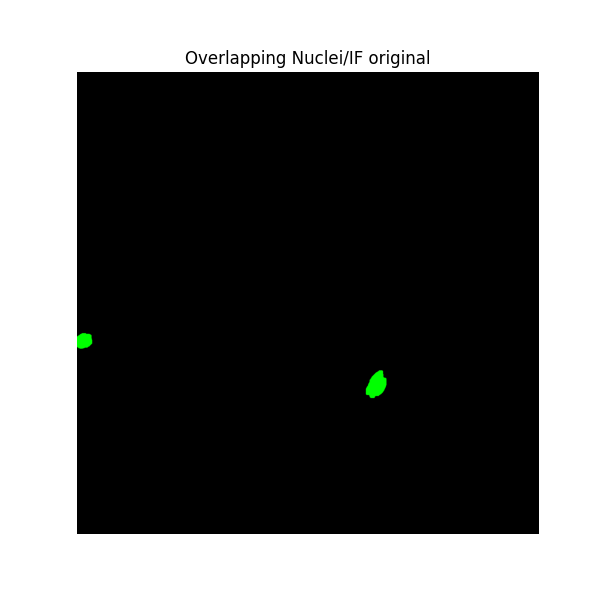

In [ ]:
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111)
# ax.axis('off')
# ax.set_title('Overlapping Nuclei/IF original')
# img_RGB = np.zeros([nuc_IF_positive.shape[0],nuc_IF_positive.shape[1],3])
# img_RGB[:,:,0] = nuclei_masks_img
# img_RGB[:,:,1] = IF_mask_img
# _ = ax.imshow(img_RGB)

# Simulation

Because the overlapping region of the images is little (probablt for the missing registration) I will run a test on synthetic images based on the nuclei

In [ ]:
# create the fake IF image
fake_image_IF = nuclei_masks_img.copy()

# get the number of labels
labels_numbers = np.unique(fake_image_IF)

In [ ]:
# Select number of labels to keep
# Good for different testing because you select new cells every time you want to build a new fake image
labels_to_keep = np.random.choice(labels_numbers,size=20)

In [ ]:
nuclei_masks_regionprop = measure.regionprops(nuclei_masks_img,extra_properties=None)


TypeError: Non-integer label_image types are ambiguous

In [ ]:
fake_image_IF =np.zeros_like(nuclei_masks_img)
for prop in nuclei_masks_regionprop:
    if prop.label in labels_to_keep:
        fake_image_IF[prop.coords[:,0],prop.coords[:,1]] = prop.label
        

In [ ]:
fake_image_IF=segmentation.expand_labels(fake_image_IF,distance=30)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
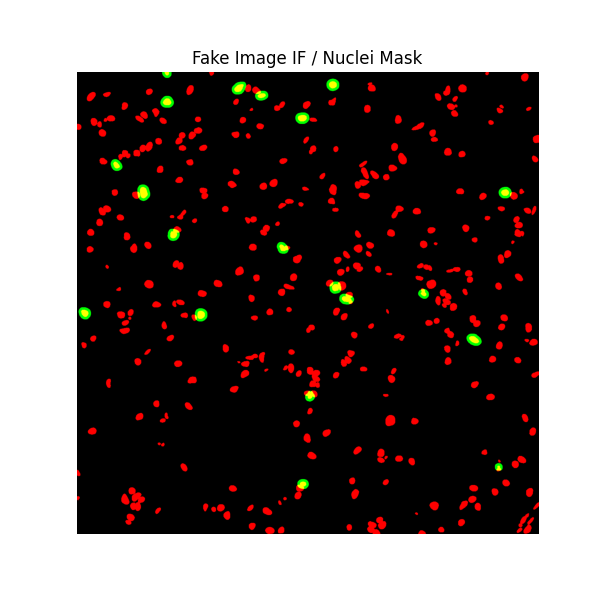

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.axis('off')
ax.set_title('Fake Image IF / Nuclei Mask')
img_RGB = np.zeros([nuc_IF_positive.shape[0],nuc_IF_positive.shape[1],3])
img_RGB[:,:,0] = nuclei_masks_img
img_RGB[:,:,1] = fake_image_IF
_ = ax.imshow(img_RGB)

In [ ]:
# current selection criteria 
# 'remove' = remove the IF mapping on the nucleus that is covering the smallest nucleus
# 'decide' = assign the entire IF data to the nucleus with larger area 
intersection_handling = 'decide' 
overlapping_region = 100

# Determine overlapping nuclei+/IF+ signal
nuc_IF_positive_regions = nuclei_masks_img.astype('bool')*fake_image_IF.astype('bool')
label_overlapping_nuclei = nuc_IF_positive*nuclei_masks_img

# Determine the labels of IF that show some overlapping
labels_overlapping_IF = np.unique(nuc_IF_positive*fake_image_IF)

# Highest label fake_image_IF
starting_add_label = fake_image_IF.max()+1

# Determine which nucleus to select if there is some overlapping
fake_img_regionprops = measure.regionprops(fake_image_IF,extra_properties=None)

matching = []

for prop in fake_img_regionprops:
    if prop.label in labels_overlapping_IF:
        cropped_region = nuclei_masks_img[prop.coords[:,0],prop.coords[:,1]]
        nuclei_labels_in_IF, counts_labels = np.unique(cropped_region,return_counts=True)
        # If the first count is 0 because you are catching the background it needs to be rmeoved
        if nuclei_labels_in_IF[0] == 0:
            nuclei_labels_in_IF = nuclei_labels_in_IF[1:]
            counts_labels = counts_labels[1:]
        # Run processing according to different criteria
        if intersection_handling == 'decide':
            selected_label = nuclei_labels_in_IF[np.where(counts_labels == counts_labels.max())[0]][0]
            matching.append((selected_label,prop.label))
            

In [ ]:
# Create image for visualization
final_nuclei_labels = [el[0] for el in matching]
final_IF_labels = [el[1] for el in matching]
removed_overlapped_IF =np.zeros_like(nuclei_masks_img)
removed_overlapped_nuclei = np.zeros_like(nuclei_masks_img)
for prop in nuclei_masks_regionprop:
    if prop.label in final_nuclei_labels:
        removed_overlapped_nuclei[prop.coords[:,0],prop.coords[:,1]] = prop.label

for prop in fake_img_regionprops:
    if prop.label in final_IF_labels:
        removed_overlapped_IF[prop.coords[:,0],prop.coords[:,1]] = prop.label
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
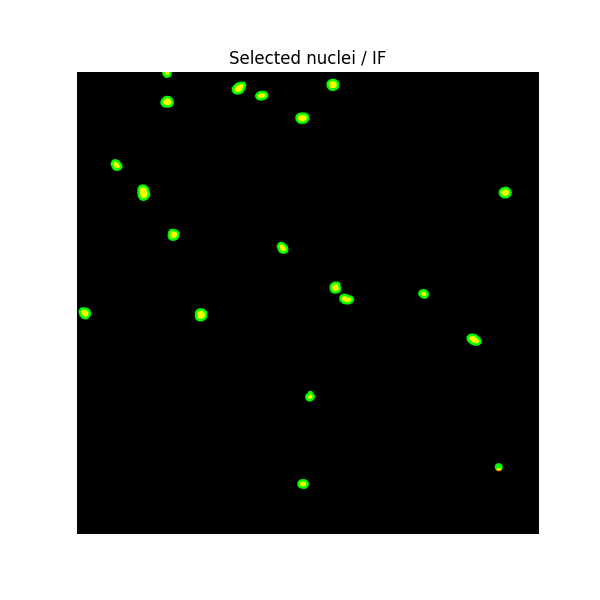

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.axis('off')
ax.set_title('Selected nuclei / IF')
img_RGB = np.zeros([nuc_IF_positive.shape[0],nuc_IF_positive.shape[1],3])
img_RGB[:,:,0] = removed_overlapped_nuclei
img_RGB[:,:,1] = removed_overlapped_IF
_ = ax.imshow(img_RGB)

In [ ]:
excluded_nuclei = ~removed_overlapped_nuclei.astype(bool)*removed_overlapped_IF.astype(bool)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
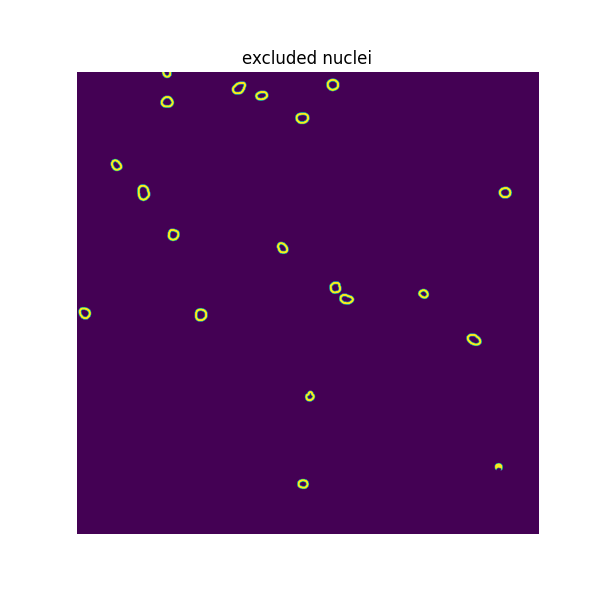

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.axis('off')
ax.set_title('excluded nuclei')
_ = ax.imshow(excluded_nuclei)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
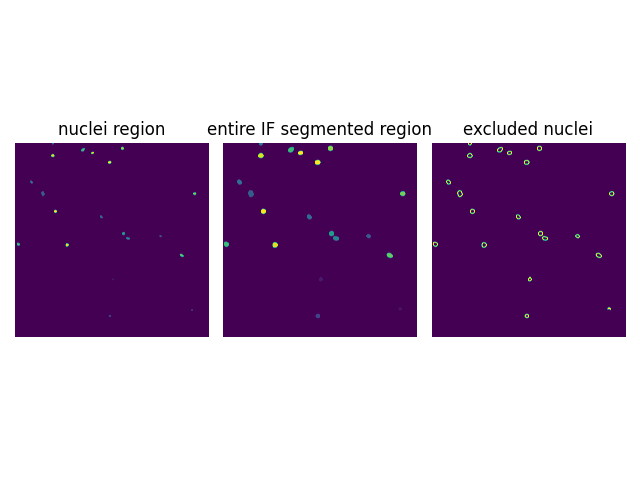

In [ ]:
# Masks used to measure in the IF image

fig, axs = plt.subplots(1, 3)

axs[0].axis('off')
axs[0].set_title('nuclei region')
_ = axs[0].imshow(removed_overlapped_nuclei)

axs[1].axis('off')
axs[1].set_title('entire IF segmented region')
_ = axs[1].imshow(removed_overlapped_IF)

axs[2].axis('off')
axs[2].set_title('excluded nuclei')
_ = axs[2].imshow(excluded_nuclei)

plt.tight_layout()